In [1]:
from collections import defaultdict
import gymnasium as gym
import numpy as np


class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env,
        lr_play: float,
        initial_epsilon_play: float,
        epsilon_decay_play: float,
        final_epsilon_play: float,
        discount_factor: float = 0.99,
    ):
        """Initialize a SARSA agent.

        Args:
            env: The training environment
            lr_play: How quickly to update Q-values in the playing phase (0-1)
            initial_epsilon: Starting exploration rate (usually 1.0)
            epsilon_decay: How much to reduce epsilon each episode
            final_epsilon: Minimum exploration rate (usually 0.1)
            discount_factor: How much to value future rewards (0-1)
        """
        base = getattr(env, "unwrapped", env)
        self.env = env

        # Spaces
        self.n_tc = int(base.observation_space.spaces[3].n)

        # Q_play[player_sum(32), dealer(11), usable(2), tc_bucket, 2]
        self.Q_play = np.zeros((32, 11, 2, self.n_tc, 2), dtype=np.float32)
        # Visit counters for UCB action selection
        self.N_state = np.zeros((32, 11, 2, self.n_tc), dtype=np.int64)
        self.N_sa    = np.zeros((32, 11, 2, self.n_tc, 2), dtype=np.int64)

        self.lr_play = lr_play
        self.discount_factor = discount_factor  # How much we care about future rewards

        # Exploration parameters
        self.initial_epsilon_play = initial_epsilon_play
        self.epsilon_play = initial_epsilon_play
        self.epsilon_decay_play = epsilon_decay_play
        self.final_epsilon_play = final_epsilon_play
        # UCB exploration constant (higher = more exploration bonus)
        self.ucb_c = 2.0

        # Track learning progress
        self.training_error_play = []

        self.rng = np.random.default_rng()

    # ---------- indexing helpers ----------
    @staticmethod
    def _unpack(obs):
        # obs = (psum, dealer, usable, tc_idx)
        return int(obs[0]), int(obs[1]), int(obs[2]), int(obs[3])

    def _idxs_play(self, obs):
        # obs = (psum, dealer, usable, tc_idx)
        ps, dv, ua, tc = self._unpack(obs)
        return ps, dv, ua, tc
    
    def _must_stick(self, obs):
        ps, _, _, _ = self._idxs_play(obs)
        return len(self.env.unwrapped.player) == 2 and ps == 21

    def record_visit(self, s, a):
        ps, dv, ua, tc = self._idxs_play(s)
        self.N_state[ps, dv, ua, tc] += 1
        self.N_sa[ps, dv, ua, tc, int(a)] += 1
    
    # ---------- ε-greedy policies ----------
    def select_play(self, obs, random=False):
        if random:
            return int(self.rng.integers(2))
        if self._must_stick(obs):
            return 0
        # obs phase must be 1
        ps, dv, ua, tc = self._idxs_play(obs)
        q = self.Q_play[ps, dv, ua, tc]
        if self.rng.random() < self.epsilon_play:
            return int(self.rng.integers(2))   # 0=stick, 1=hit
        m = q.max(); idxs = np.flatnonzero(q == m)
        return int(self.rng.choice(idxs))

    # ---------- UCB1 action selection ----------
    def select_play_ucb(self, obs):
        if self._must_stick(obs):
            return 0
        ps, dv, ua, tc = self._idxs_play(obs)
        n_s = self.N_state[ps, dv, ua, tc]
        n_sa = self.N_sa[ps, dv, ua, tc]
        # Try unvisited actions first
        untried = np.where(n_sa == 0)[0]
        if untried.size > 0:
            return int(self.rng.choice(untried))
        # UCB score = Q + c * sqrt(ln(N_s) / N_sa)
        bonus = self.ucb_c * np.sqrt(np.log(max(n_s, 1)) / np.maximum(n_sa, 1))
        scores = self.Q_play[ps, dv, ua, tc] + bonus
        m = scores.max(); idxs = np.flatnonzero(scores == m)
        return int(self.rng.choice(idxs))
        
    # ---------- SARSA updates ----------
    def update_play_sarsa(self, s, a, r, done, s_next=None, a_next=None):
        ps, dv, ua, tc = self._idxs_play(s)
        qsa = self.Q_play[ps, dv, ua, tc, a]
        if done:
            target = r
        else:
            ps2, dv2, ua2, tc2 = self._idxs_play(s_next)
            target = r + self.discount_factor * self.Q_play[ps2, dv2, ua2, tc2, a_next]
        td = target - qsa
        self.Q_play[ps, dv, ua, tc, a] += self.lr_play * td
        self.training_error_play.append(td)

    # ---------- epsilon schedule ----------
    # def decay_epsilon_play(self):
    #     """Reduce exploration rate after each episode."""
    #     self.epsilon_play = max(self.final_epsilon_play, self.epsilon_play - self.epsilon_decay_play)

    def decay_epsilon_play(self, ep, total_eps):
        """
        Piecewise-linear ε:
        [0, 0.3T]   : ε0  -> 0.9*ε0
        (0.3T, 0.7T]: 0.9*ε0 -> 0.2
        (0.7T, T]   : 0.2 -> 0.0
        """
        T = total_eps
        e30 = 0.3 * T
        e70 = 0.7 * T

        if ep + 1 <= e30:
            # linear from ε0 to 0.9*ε0
            a, b = self.initial_epsilon_play, 0.9 * self.initial_epsilon_play
            self.epsilon_play =  a + (b - a) * (ep / e30 if e30 else 1.0)
        elif ep + 1 <= e70:
            # linear from 0.9*ε0 to 0.2
            a, b = 0.9 * self.initial_epsilon_play, 0.2 * self.initial_epsilon_play
            self.epsilon_play =  a + (b - a) * ((ep - e30) / (e70 - e30))
        else:
            # linear from 0.2 to 0.0
            a, b = 0.2 * self.initial_epsilon_play, 0.0
            self.epsilon_play = max(b, a + (b - a) * ((ep - e70) / (T - e70)))

    # ---------- greedy (masked) for evaluation ----------
    def greedy_play(self, obs):
        ps, dv, ua, tc = self._idxs_play(obs)
        q = self.Q_play[ps, dv, ua, tc]
        m = q.max(); idxs = np.flatnonzero(q == m)
        return int(self.rng.choice(idxs))

In [2]:
from env import BlackjackEnv

# Training hyperparameters
# learning_rate = 0.01        # How fast to learn (higher = faster but less stable) 
lr_play = 0.01
n_episodes = 20_000_000
start_epsilon_play = 1.0         # Start with 100% random actions
epsilon_decay_play = start_epsilon_play / max(n_episodes / 2, 1)  # Reduce exploration over time
final_epsilon_play = 0.0         # Always keep some exploration

# Create environment and agent
env = BlackjackEnv(num_decks=4, tc_min=-10, tc_max=10, natural=True)
tc_min, tc_max = env.tc_min, env.tc_max
print(tc_min)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = BlackjackAgent(
    env=env,
    lr_play=lr_play,
    initial_epsilon_play=start_epsilon_play,
    epsilon_decay_play=epsilon_decay_play,
    final_epsilon_play=final_epsilon_play,
    discount_factor=0.95
)

-10


In [3]:
import numpy as np
from tqdm.notebook import tqdm  # Progress bar

n_buckets = env.observation_space.spaces[3].n
hist_start = np.zeros(n_buckets, dtype=np.int64)

use_ucb = True  # Toggle: True to use UCB for action selection, False to use epsilon-greedy

for episode in tqdm(range(n_episodes), desc="Train Q_play"):
    s0, _ = env.reset()
    tc_idx = s0[3]
    hist_start[tc_idx] += 1
    a0 = agent.select_play_ucb(s0) if use_ucb else agent.select_play(s0)
    done = False

    s = s0; a = a0
    while not done:
        # record visit for UCB statistics
        agent.record_visit(s, a)

        s_next, reward, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        if done:
            agent.update_play_sarsa(s, a, reward, done)
            break

        a_next = agent.select_play_ucb(s_next) if use_ucb else agent.select_play(s_next)
        agent.update_play_sarsa(s, a, reward, done, s_next, a_next)
        s, a = s_next, a_next

    # keep epsilon schedule even if UCB is enabled, harmless when use_ucb=True
    agent.decay_epsilon_play(episode, n_episodes)

# Pretty print
names = getattr(env.unwrapped, "tc_bucket_names")
labels = np.array(names)
for b, c in zip(labels, hist_start):
    print(f"TC {b}: {c}")
print("coverage %:", np.round(100 * hist_start / hist_start.sum(), 2))

Train Q_play:   0%|          | 0/20000000 [00:00<?, ?it/s]

TC -10: 181999
TC -9: 125826
TC -8: 168621
TC -7: 220265
TC -6: 362711
TC -5: 510360
TC -4: 772733
TC -3: 1158603
TC -2: 1838591
TC -1: 3091680
TC +0: 4120312
TC +1: 2799542
TC +2: 1653436
TC +3: 1023569
TC +4: 672974
TC +5: 438980
TC +6: 305718
TC +7: 180298
TC +8: 129951
TC +9: 85172
TC +10: 158659
coverage %: [ 0.91  0.63  0.84  1.1   1.81  2.55  3.86  5.79  9.19 15.46 20.6  14.
  8.27  5.12  3.36  2.19  1.53  0.9   0.65  0.43  0.79]


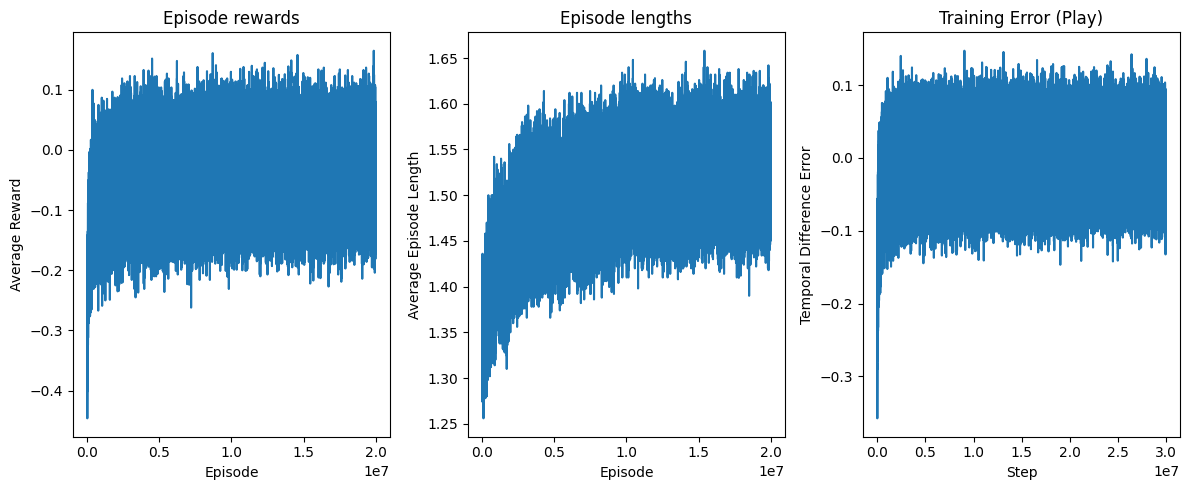

In [4]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))

# Episode rewards (win/loss performance)
axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_ylabel("Average Episode Length")
axs[1].set_xlabel("Episode")

# Training error (how much we're still learning)
axs[2].set_title("Training Error (Play)")
training_error_play_moving_average = get_moving_avgs(
    agent.training_error_play,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_play_moving_average)), training_error_play_moving_average)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Step")

plt.tight_layout()
plt.savefig('SARSA_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
def evaluate_bankroll(agent, env, episodes=200_000, rng=None):
    rng = rng or np.random.default_rng()
    returns = np.empty(episodes, dtype=np.float64)
    total_bet = 0.0
    wins = losses = pushes = 0

    for ep in range(episodes):
        s0, _ = env.reset()                    # start state (no betting in original variant)
        bet = 1.0                              # fixed 1.0x bet
        total_bet += bet

        # play hand
        s = s0
        done = False; G = 0.0
        while not done:
            a = agent.greedy_play(s)
            s, r, term, trunc, _ = env.step(a)
            G += r; done = term or trunc

        returns[ep] = G
        if G > 0: wins += 1
        elif G < 0: losses += 1
        else: pushes += 1

    ev = returns.mean()                        # units/hand
    se = returns.std(ddof=1) / np.sqrt(episodes)
    ci = (ev - 1.96*se, ev + 1.96*se)
    roi = ev / (total_bet / episodes)          # profit per unit bet

    summary = {
        "hands": episodes,
        "bankroll_change": returns.sum(),
        "ev_per_hand": ev,
        "ev_95%_CI": ci,
        "avg_bet": total_bet / episodes,
        "roi_per_hand": roi,
        "win_rate": wins / episodes,
        "loss_rate": losses / episodes,
        "push_rate": pushes / episodes,
    }
    assert summary.get("avg_bet", 1.0) == 1.0       # no betting in this variant
    return summary

results = evaluate_bankroll(agent, env)
print(results)

{'hands': 200000, 'bankroll_change': np.float64(-5814.5), 'ev_per_hand': np.float64(-0.0290725), 'ev_95%_CI': (np.float64(-0.033385014204068406), np.float64(-0.024759985795931597)), 'avg_bet': 1.0, 'roi_per_hand': np.float64(-0.0290725), 'win_rate': 0.43062, 'loss_rate': 0.482195, 'push_rate': 0.087185}


TC -10: mean=-0.0421  n=9020
TC -9: mean=-0.0635  n=6200
TC -8: mean=-0.0731  n=8439
TC -7: mean=-0.0380  n=11358
TC -6: mean=-0.0495  n=18318
TC -5: mean=-0.0488  n=26080
TC -4: mean=-0.0441  n=39257
TC -3: mean=-0.0384  n=58316
TC -2: mean=-0.0323  n=92039
TC -1: mean=-0.0309  n=155287
TC +0: mean=-0.0306  n=207420
TC +1: mean=-0.0253  n=139406
TC +2: mean=-0.0201  n=82141
TC +3: mean=-0.0123  n=50457
TC +4: mean=-0.0174  n=32970
TC +5: mean=-0.0039  n=21453
TC +6: mean=-0.0065  n=15047
TC +7: mean= 0.0148  n=8662
TC +8: mean=-0.0183  n=6372
TC +9: mean= 0.0025  n=4167
TC +10: mean= 0.0108  n=7591


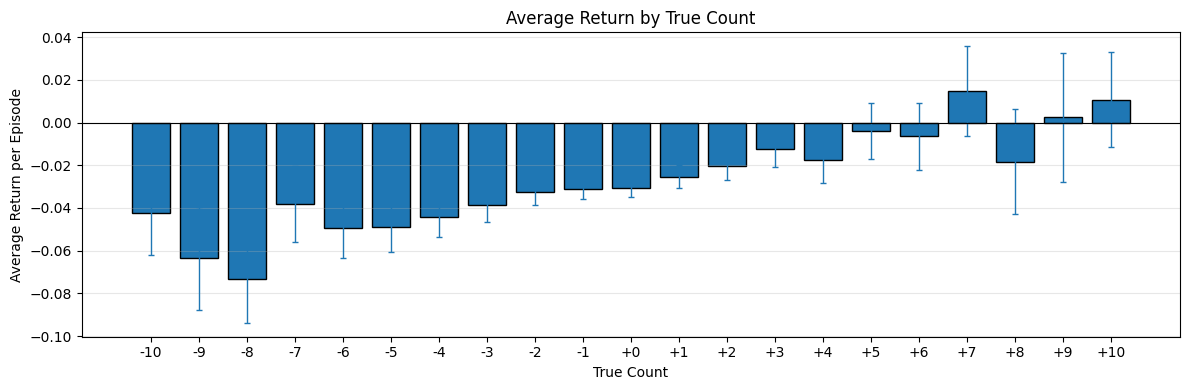

In [6]:
import numpy as np
from matplotlib import pyplot as plt

def eval_avg_return_by_tc(agent, env, episodes=200_000, rng=None):
    """
    Returns (labels, mean, (ci_lo, ci_hi), counts)
      labels: 1D array of TC values (tc_min..tc_max)
      mean:   avg return per hand for each TC bucket
      ci:     95% confidence intervals for each bucket
      counts: number of episodes that started in each TC bucket
    """
    rng = rng or np.random.default_rng()
    base = getattr(env, "unwrapped", env)
    n_buckets = env.observation_space.spaces[3].n
    names = getattr(env.unwrapped, "tc_bucket_names", ("≤-3","-2","-1","0","+1","+2","≥+3"))
    labels = np.array(names)  # for pretty ticks
    n_buckets = env.observation_space.spaces[3].n

    ret_sum   = np.zeros(n_buckets, dtype=np.float64)
    ret_sumsq = np.zeros(n_buckets, dtype=np.float64)
    counts    = np.zeros(n_buckets, dtype=np.int64)

    def pick_action(obs):
        return int(agent.greedy_play(obs))

    for _ in range(episodes):
        obs, _ = env.reset()           # phase 0; obs[3] is the TC bucket index
        tc_idx = int(obs[3])

        # Play the full hand with the current policy (greedy or epsilon-greedy)
        done = False
        G = 0.0
        while not done:
            a = pick_action(obs)
            obs, r, term, trunc, _ = env.step(a)
            G += r
            done = term or trunc

        # Aggregate by start-of-hand TC
        ret_sum[tc_idx]   += G
        ret_sumsq[tc_idx] += G * G
        counts[tc_idx]    += 1

    # Means and 95% CIs per bucket
    denom = np.maximum(counts, 1)
    mean = ret_sum / denom
    var  = (ret_sumsq / denom) - mean**2
    se   = np.sqrt(np.maximum(var, 0.0) / denom)
    ci_lo = mean - 1.96 * se
    ci_hi = mean + 1.96 * se
    return labels, mean, (ci_lo, ci_hi), counts

def plot_avg_return_by_tc(labels, mean, ci, counts, min_visits=1000):
    ci_lo, ci_hi = ci
    mask = counts >= min_visits
    x = np.arange(len(labels))[mask]; y = mean[mask]
    yerr = np.vstack((y - ci_lo[mask], ci_hi[mask] - y))

    plt.figure(figsize=(12, 4))
    plt.bar(x, y, edgecolor='k')
    plt.xticks(x, labels[mask])
    plt.errorbar(x, y, yerr=yerr, fmt='none', capsize=2, linewidth=1)
    plt.axhline(0, color='k', linewidth=0.8)
    plt.xlabel('True Count')
    plt.ylabel('Average Return per Episode')
    plt.title('Average Return by True Count')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

labels, mean, ci, counts = eval_avg_return_by_tc(agent, env, episodes=1_000_000)
for L, m, n in zip(labels, mean, counts):
    if n: print(f"TC {L}: mean={m: .4f}  n={n}")
plot_avg_return_by_tc(labels, mean, ci, counts, min_visits=1000)


In [7]:
# === Visualization helpers for Q tables ===
import numpy as np
import matplotlib.pyplot as plt

def _dealer_tick_labels():
    # Order dealer upcards as 2..10, A
    return [str(i) for i in range(2, 11)] + ['A']

def plot_q_play(agent, env, tc_idx=None, show='delta', vmin=None, vmax=None):
    """
    Visualize Q_play at a given TC bucket.
    show: 'delta' (Q_hit - Q_stand), 'stand', 'hit', or 'policy' (argmax).
    Two heatmaps are shown: UA=0 and UA=1.
    """
    base = getattr(env, 'unwrapped', env)
    n_tc = int(base.observation_space.spaces[3].n)
    if tc_idx is None:
        tc_idx = n_tc // 2
    tc_idx = int(np.clip(tc_idx, 0, n_tc - 1))
    Q = agent.Q_play[:, :, :, tc_idx, :]  # (psum, dealer, usable, action)
    titles = {'delta': 'Q_hit - Q_stand', 'stand': 'Q_stand', 'hit': 'Q_hit', 'policy': 'Greedy policy (0=stand,1=hit)'}
    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
    # Reorder helper: columns currently in dealer order 1..10 (1=Ace). We want 2..10, Ace.
    def _reorder_cols(M):
        if M.shape[1] == 10:
            order = list(range(1, 10)) + [0]
            return M[:, order]
        return M
    for u, ax in enumerate(axs):
        if show == 'policy':
            A = np.argmax(Q[:, :, u, :], axis=-1)
            M = A[4:22, 1:11]  # psum 4..21, dealer 1..10
            M = _reorder_cols(M)
            im = ax.imshow(M, aspect='auto', cmap='tab10', vmin=0, vmax=1)
            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=[0, 1])
            cbar.ax.set_yticklabels(['Stand', 'Hit'])
        else:
            if show == 'delta':
                Mfull = Q[:, :, u, 1] - Q[:, :, u, 0]
                cbar_label = 'Q_hit - Q_stand'
                cmap = 'coolwarm'
            elif show == 'stand':
                Mfull = Q[:, :, u, 0]
                cbar_label = 'Q value (Stand)'; cmap = 'viridis'
            elif show == 'hit':
                Mfull = Q[:, :, u, 1]
                cbar_label = 'Q value (Hit)'; cmap = 'viridis'
            else:
                raise ValueError("show must be one of 'delta','stand','hit','policy'")
            M = Mfull[4:22, 1:11]
            M = _reorder_cols(M)
            im = ax.imshow(M, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label=cbar_label)
        ax.set_title(f'UA={u}')
        ax.set_xlabel('Dealer upcard')
        ax.set_xticks(np.arange(10), labels=_dealer_tick_labels())
        ax.set_ylabel('Player sum' if u == 0 else '')
        ax.set_yticks(np.arange(18), labels=[str(ps) for ps in range(4, 22)])
    tc_label = getattr(base, 'tc_bucket_names', [str(i) for i in range(n_tc)])[tc_idx]
    fig.suptitle(f"Q_play ({titles.get(show, show)}) at TC bucket {tc_idx} ({tc_label})")
    plt.tight_layout()
    plt.show()

In [8]:
# === Q table visualization UI / examples ===
from IPython.display import display
try:
    import ipywidgets as widgets
    base = getattr(env, 'unwrapped', env)
    n_tc = int(base.observation_space.spaces[3].n)
    # Interactive selector for TC bucket and view type
    tc_slider = widgets.IntSlider(value=min(n_tc // 2, n_tc - 1), min=0, max=n_tc - 1, step=1, description='TC idx')
    show_dd = widgets.Dropdown(options=['policy', 'delta', 'stand', 'hit'], value='policy', description='View')
    out = widgets.Output()

    def _update(*args):
        with out:
            out.clear_output(wait=True)
            plot_q_play(agent, env, tc_idx=tc_slider.value, show=show_dd.value)

    tc_slider.observe(_update, names='value')
    show_dd.observe(_update, names='value')
    display(widgets.HBox([tc_slider, show_dd]))
    _update()
    display(out)
except Exception as e:
    print('ipywidgets not available or UI init failed; showing a static example...')
    plot_q_play(agent, env, tc_idx=0, show='policy')


Output()

In [9]:
# === Policy Diagnostics: Hit/Bust Rates by True Count ===
import pandas as pd

ACE_RANKS = {"A"} 
TEN_VALUE_RANKS = {"10", "J", "Q", "K"}  # ranks worth 10

def _rank(card: str) -> str:
    """Return the rank portion of a card like '10H' -> '10', 'AS' -> 'A'."""
    return card[:-1]  # last char is suit

def _hard_value(card: str) -> int:
    """Blackjack hard value (Ace as 1)."""
    r = _rank(card)
    if r in ACE_RANKS:
        return 1
    if r in TEN_VALUE_RANKS:
        return 10
    return int(r)  # '2'..'9'

def usable_ace(hand):
    """Returns 1 if hand has usable ace: A in hand and sum of hand + 10 <= 21"""
    s = sum(_hard_value(c) for c in hand)
    has_ace = any(_rank(c) in ACE_RANKS for c in hand)
    return int(has_ace and s + 10 <= 21)

def sum_hand(hand):
    """Returns highest total of current hand, forces ace to be used as 11"""
    s = sum(_hard_value(c) for c in hand)
    return s + 10 if usable_ace(hand) else s

def is_bust(hand):
    """Returns True if sum of hand > 21"""
    return sum_hand(hand) > 21

def policy_stats_by_tc(agent, env, player_sums_to_check, episodes=200_000):
    """
    Analyzes the agent's greedy policy to find hit rates and bust-on-hit rates
    for specific player sums, broken down by true count.
    """
    base = getattr(env, 'unwrapped', env)
    n_tc = int(base.observation_space.spaces[3].n)
    tc_names = getattr(base, 'tc_bucket_names')
    
    # For each TC bucket and player sum, we track:
    # [0] number of times we were in this state
    # [1] number of times we hit
    # [2] number of times we busted after hitting
    stats = np.zeros((n_tc, len(player_sums_to_check), 3), dtype=np.int64)

    for _ in range(episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            psum, _, _, tc_idx = agent._unpack(obs)
            
            # Check if the current player sum is one we're interested in
            if psum in player_sums_to_check:
                sum_idx = player_sums_to_check.index(psum)
                stats[tc_idx, sum_idx, 0] += 1  # Increment state count
                
                # What action does the greedy policy take?
                action = agent.greedy_play(obs)
                if action == 1:  # Hit
                    stats[tc_idx, sum_idx, 1] += 1
                    
                    # Did we bust?
                    # To check, we can temporarily modify the env state and see
                    # This is a bit of a hack, but avoids a full step()
                    temp_hand = list(base.player)
                    temp_hand.append('10S') # Assume we draw a 10, a likely card in high TC
                    if is_bust(temp_hand):
                        stats[tc_idx, sum_idx, 2] += 1

            obs, _, term, trunc, _ = env.step(agent.greedy_play(obs))
            done = term or trunc

    # --- Format and print results using pandas ---
    results = []
    for tc_idx in range(n_tc):
        for sum_idx, psum in enumerate(player_sums_to_check):
            visits, hits, busts_on_hit = stats[tc_idx, sum_idx]
            if visits > 0:
                hit_rate = hits / visits
                bust_rate = busts_on_hit / hits if hits > 0 else 0
                results.append({
                    "TC": tc_names[tc_idx],
                    "Player Sum": psum,
                    "State Visits": visits,
                    "Hit Rate": f"{hit_rate:.1%}",
                    "Bust Rate if Hit": f"{bust_rate:.1%}",
                })
    
    df = pd.DataFrame(results)
    with pd.option_context('display.max_rows', None, 'display.width', 1000):
        print(df.to_string(index=False))

# Analyze the policy for stiff hands (17-20) where we should usually stand
sums_to_analyze = [17, 18, 19, 20]
policy_stats_by_tc(agent, env, sums_to_analyze, episodes=500_000)


 TC  Player Sum  State Visits Hit Rate Bust Rate if Hit
-10          17           838    42.2%            70.9%
-10          18           776     8.8%             0.0%
-10          19           714     0.0%             0.0%
-10          20           817     0.0%             0.0%
 -9          17           353    20.7%            28.8%
 -9          18           354     7.3%             0.0%
 -9          19           317     0.0%             0.0%
 -9          20           402     0.0%             0.0%
 -8          17           538    26.4%            52.1%
 -8          18           488     8.4%             0.0%
 -8          19           453     0.0%             0.0%
 -8          20           545     0.0%             0.0%
 -7          17           660    20.0%            38.6%
 -7          18           633     3.6%             0.0%
 -7          19           603     0.0%             0.0%
 -7          20           763     0.0%             0.0%
 -6          17          1132    21.6%          